In [1]:
%pylab notebook
import numpy as np
import pandas as pd
import os

from datetime import datetime

import cognite
from cognite.client import CogniteClient

import statsmodels.graphics.tsaplots

import seaborn as sns

from matplotlib import pyplot

import sklearn
from sklearn import preprocessing
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [136]:
client = CogniteClient(api_key='N2YxNDA5YWYtMjFkMy00ZjU1LWJhNjYtYmM5NTEzN2FlMjE3')

In [3]:
assets = client.assets.get_assets()
assests_df = assets.to_pandas()

In [4]:
root_asset_id = assests_df[assests_df.path.str.len() == 1].path[0][0]
subtree = client.assets.get_asset_subtree(root_asset_id, depth = 4)
assetIdList = list(subtree.to_pandas().id)
subtree.to_pandas()

,createdTime,depth,description,id,lastUpdatedTime,name,parentId,path
0,1552502284331,0,Compressor Root Node,1037746305713660,1552502284331,23 1ST STAGE COMPRESSOR,NaN,[1037746305713660]
1,1552502465341,1,Compressor Outputs,1517936992864816,1552502465341,23 1ST STAGE COMPRESSOR - OUTPUTS,1.037746e+15,"[1037746305713660, 1517936992864816]"
2,1552502482013,1,Compressor Controls,2304223245973450,1552502482013,23 1ST STAGE COMPRESSOR - CONTROLS,1.037746e+15,"[1037746305713660, 2304223245973450]"
3,1552502438789,1,Compressor Inputs,2340545933969985,1552502438789,23 1ST STAGE COMPRESSOR - INPUTS,1.037746e+15,"[1037746305713660, 2340545933969985]"


In [5]:
tsList = []
totalAssets = len(assetIdList)
for x in (assetIdList):
    tsList.append(client.time_series.get_time_series(asset_id=x, autopaging=True))
tsList.pop(0)
allTSNames = []

In [137]:
allTSNames = ['VAL_23-FT-92512:X.Value', 'VAL_23-PT-92532:X.Value', 'VAL_23-TT-92533:X.Value', 'VAL_23-FT-92537-01:X.Value', 'VAL_23-FT-92537-04:X.Value', 'VAL_23-PT-92539:X.Value', 'VAL_23-TT-92539:X.Value', 'VAL_23_ZT_92543:Z.X.Value', 'VAL_23_ZT_92538:Z.X.Value', 'VAL_23-KA-9101_ASP:VALUE']
start = datetime(2016, 10, 1)
end = datetime(2019, 1, 31)
data = client.datapoints.get_datapoints_frame(allTSNames, start=start, granularity='10m', aggregates=['average'])
data.tail()

,timestamp,VAL_23-FT-92512:X.Value|average,VAL_23-PT-92532:X.Value|average,VAL_23-TT-92533:X.Value|average,VAL_23-FT-92537-01:X.Value|average,VAL_23-FT-92537-04:X.Value|average,VAL_23-PT-92539:X.Value|average,VAL_23-TT-92539:X.Value|average,VAL_23_ZT_92543:Z.X.Value|average,VAL_23_ZT_92538:Z.X.Value|average,VAL_23-KA-9101_ASP:VALUE|average
102845,1537229400000,95985.940308,2.758834,33.789883,163323.317056,47958.732060,NaN,124.580136,38.775727,85.987317,9062.199390
102846,1537230000000,95387.038334,2.753966,33.501275,162519.083527,47726.139366,NaN,124.404915,38.538753,85.128595,8975.784712
102847,1537230600000,96901.124914,2.761908,33.660839,160903.054665,47184.877474,NaN,124.920648,37.039554,85.584894,8925.057769
102848,1537231200000,94910.238093,2.714019,33.481544,160698.737847,47697.127872,NaN,124.574032,37.997461,84.051158,8964.368109
102849,1537231800000,94449.228510,2.765878,33.172383,161750.451973,47305.150106,NaN,124.212568,38.611948,85.435267,8933.268402


In [103]:
data = data.fillna(method='ffill')
train1 = data.drop(data.columns[5], axis = 'columns')
train2 = data.drop(data.columns[4], axis = 'columns')
train3 = data.drop(data.columns[4:6], axis = 'columns')
test1 = data.drop(data.columns[5], axis = 'columns')
test2 = data.drop(data.columns[4], axis = 'columns')
test3 = data.drop(data.columns[4:6], axis = 'columns')

T = list(pd.to_datetime(data.timestamp, unit='ms'))

In [105]:
train1_begin = 1475280000000
train1_end = 1505433000000

train2_begin = 1509528600000
train2_end = 1521330600000

train3_begin = 1475280000000
train3_end = 1521330600000

test_begin1 = 1521330000000
test_begin2 = 1521330600000 - (2* 600000)
test_begin3 = 1521330000000
test_end = 1537231800000

In [106]:
train1 = train1[(train1.timestamp >= train1_begin) & (train1.timestamp <= train1_end)]
train2 = train2[(train2.timestamp >= train2_begin) & (train2.timestamp <= train2_end)]
train3 = train3[(train3.timestamp >= train3_begin) & (train3.timestamp <= train3_end)]
test1 = test1[(test1.timestamp >= test_begin1) & (test1.timestamp <= test_end)]
test2 = test2[(test2.timestamp >= test_begin2) & (test2.timestamp <= test_end)]
test3 = test3[(test3.timestamp >= test_begin3) & (test3.timestamp <= test_end)]

In [107]:
train1 = train1.fillna(method='ffill')
train2 = train2.fillna(method='ffill')
train3 = train3.fillna(method='ffill')
test1 = test1.fillna(method='ffill')
test2 = test2.fillna(method='ffill')
test3 = test3.fillna(method='ffill')

In [108]:
train1['timestamp'] = pd.to_datetime(train1.timestamp, unit='ms')
train2['timestamp'] = pd.to_datetime(train2.timestamp, unit='ms')
train3['timestamp'] = pd.to_datetime(train3.timestamp, unit='ms')
test1['timestamp'] = pd.to_datetime(test1.timestamp, unit='ms')
test2['timestamp'] = pd.to_datetime(test2.timestamp, unit='ms')
test3['timestamp'] = pd.to_datetime(test3.timestamp, unit='ms')

In [109]:
train1 = train1.set_index('timestamp')
train2 = train2.set_index('timestamp')
train3 = train3.set_index('timestamp')
test1 = test1.set_index('timestamp')
test2 = test2.set_index('timestamp')
test3 = test3.set_index('timestamp')

In [116]:
def data_prep(data, target_col_name, val_percent, lag_steps):
    #print(len(data[target_col_name].values))
    #print(data.shape)
    #print(data.isna().sum())
    target_vals = data[target_col_name].values[lag_steps:]
    
    data = data.drop(target_col_name, axis = 'columns')
    #print(data.head())
    
    values = data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    norm_values = scaler.fit_transform(values)
    
    train_data = series_to_supervised(norm_values, lag_steps, 1)
    #print(len(target_vals), train_data.shape)
    #print(train_data.head())
    #print(len(target_vals))
    train_data['target'] = target_vals
    
    train_data = train_data.drop(train_data.columns[:len(data.columns)], axis = 'columns')
    train_vals = train_data.values
    
    index = int(train_data.shape[0] * val_percent)

    X_train, y_train = train_vals[:index, :-1], train_vals[:index, -1]
    X_val, y_val = train_vals[index:, :-1], train_vals[index:, -1]

    X_train = X_train.reshape((X_train.shape[0], lag_steps, int(X_train.shape[1]/lag_steps)))
    X_val = X_val.reshape((X_val.shape[0], lag_steps, int(X_val.shape[1]/lag_steps)))

    return X_train, y_train, X_val, y_val

    
def build_model(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    print(X_val.shape, y_val.shape)
    history = model.fit(X_train, y_train, epochs=60, batch_size=6*24, validation_data=(X_val, y_val), verbose=2, shuffle=False)
    
    return model

def compute_pred(data, target_col_name, val_percent, lag_steps):
    X_train, y_train, X_val, y_val = data_prep(data, target_col_name, val_percent, lag_steps)
    model = build_model(X_train, y_train, X_val, y_val)
    val_pred = model.predict(X_val)
    train_pred = model.predict(X_train)

    
    return train_pred, y_train, val_pred, y_val, model

def graph_pred(y, yhat):
    T = pd.to_datetime(data.timestamp, unit='ms')
    plt.figure(figsize=(10, 5))
    plt.plot( y, label='y', color = 'red')
    plt.plot( yhat, label='y_hat')
    plt.legend()
    plt.show()
    
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [125]:
train_pred1, y_train1, val_pred, y_val, model1 = compute_pred(train1, 'VAL_23-PT-92539:X.Value|average', 1, 2)
train_pred2, y_train2, val_pred, y_val, model2 = compute_pred(train2, 'VAL_23-PT-92539:X.Value|average', 1, 3)
train_pred3, y_train3, val_pred, y_val, model3 = compute_pred(train3, 'VAL_23-PT-92539:X.Value|average', 1, 2)

(0, 2, 8) (0,)
Train on 49944 samples, validate on 0 samples
Epoch 1/60
 - 5s - loss: 39.4766
Epoch 2/60
 - 2s - loss: 0.1225
Epoch 3/60
 - 2s - loss: 0.1098
Epoch 4/60
 - 1s - loss: 0.0981
Epoch 5/60
 - 1s - loss: 0.0880
Epoch 6/60
 - 1s - loss: 0.0796
Epoch 7/60
 - 1s - loss: 0.0724
Epoch 8/60
 - 1s - loss: 0.0660
Epoch 9/60
 - 1s - loss: 0.0604
Epoch 10/60
 - 1s - loss: 0.0554
Epoch 11/60
 - 1s - loss: 0.0507
Epoch 12/60
 - 1s - loss: 0.0464
Epoch 13/60
 - 1s - loss: 0.0427
Epoch 14/60
 - 1s - loss: 0.0394
Epoch 15/60
 - 1s - loss: 0.0365
Epoch 16/60
 - 1s - loss: 0.0340
Epoch 17/60
 - 1s - loss: 0.0316
Epoch 18/60
 - 1s - loss: 0.0291
Epoch 19/60
 - 1s - loss: 0.0266
Epoch 20/60
 - 1s - loss: 0.0240
Epoch 21/60
 - 1s - loss: 0.0215
Epoch 22/60
 - 1s - loss: 0.0193
Epoch 23/60
 - 1s - loss: 0.0174
Epoch 24/60
 - 1s - loss: 0.0157
Epoch 25/60
 - 2s - loss: 0.0143
Epoch 26/60
 - 2s - loss: 0.0131
Epoch 27/60
 - 2s - loss: 0.0122
Epoch 28/60
 - 1s - loss: 0.0115
Epoch 29/60
 - 1s - los

In [126]:
X_test1, y_train, X_val, y_val = data_prep(test1, 'VAL_23-PT-92539:X.Value|average', 1, 2)
X_test2, y_train, X_val, y_val = data_prep(test2, 'VAL_23-PT-92539:X.Value|average', 1, 3)
X_test3, y_train, X_val, y_val = data_prep(test3, 'VAL_23-PT-92539:X.Value|average', 1, 2)

<IPython.core.display.Javascript object>


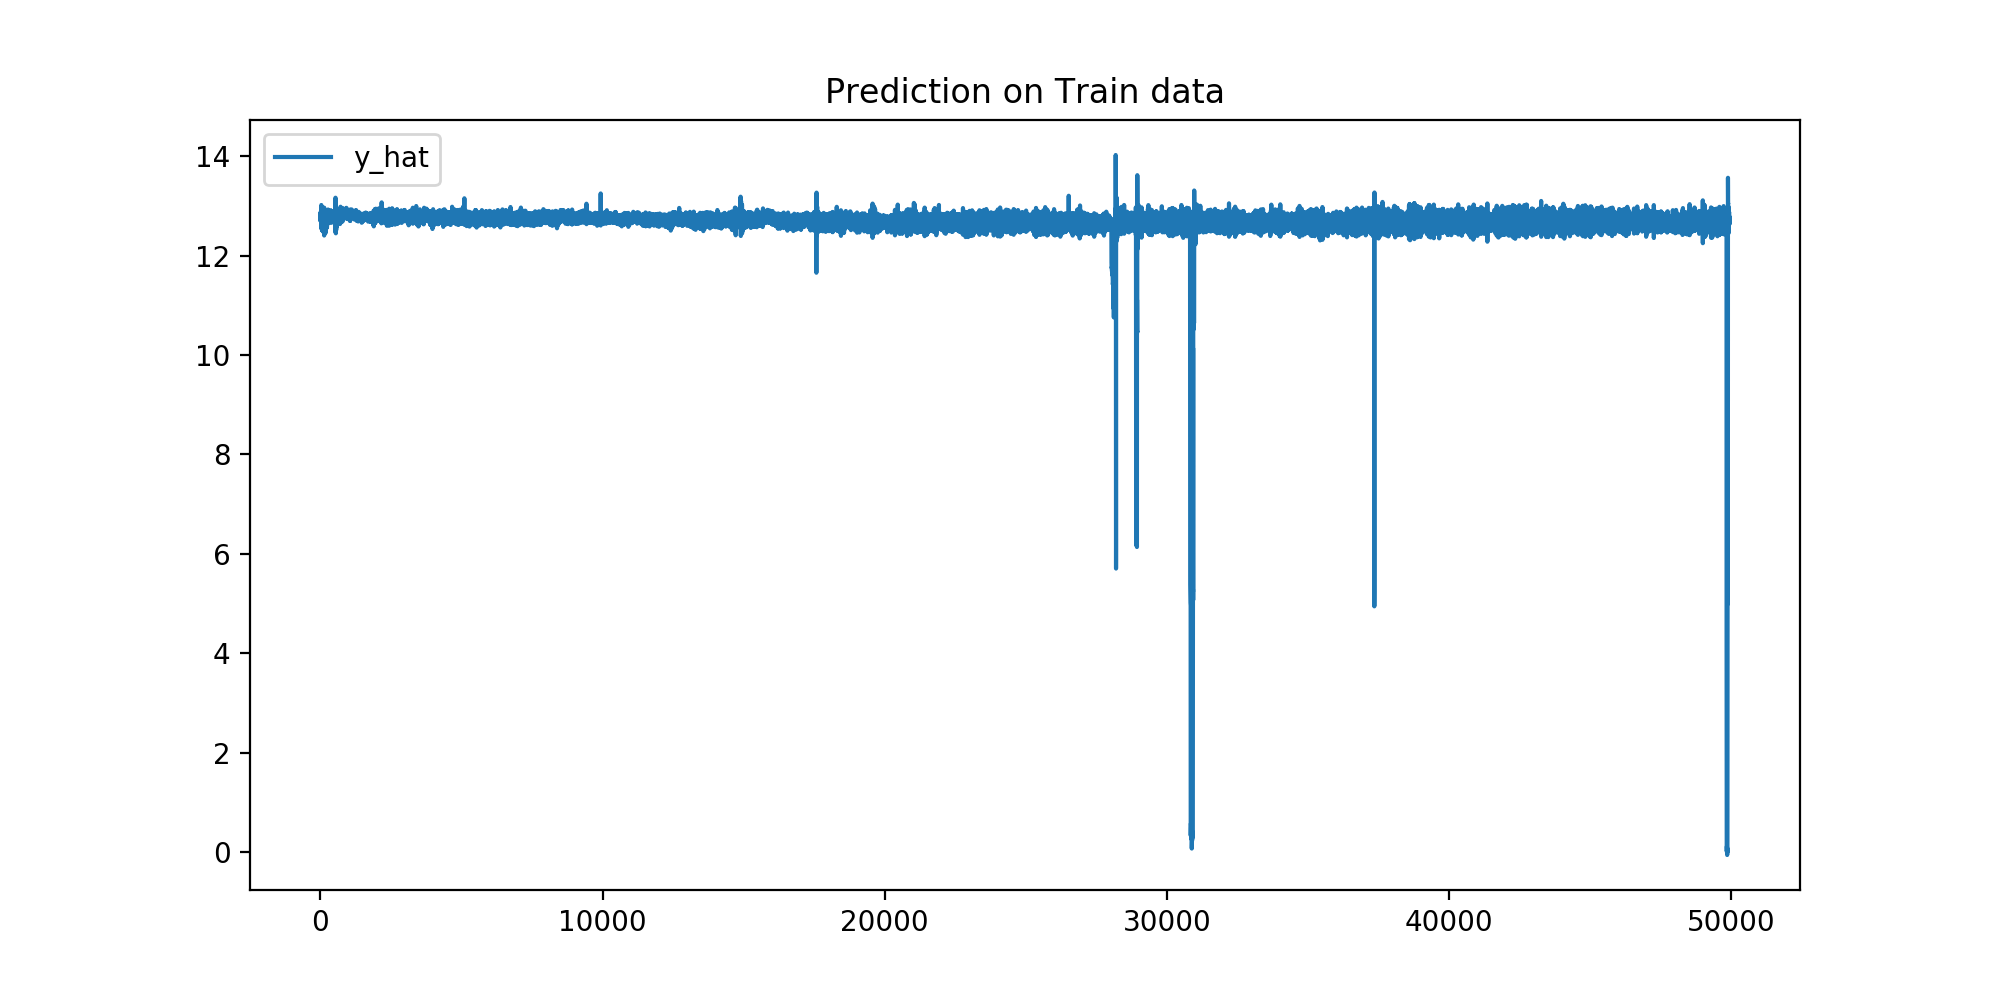

In [132]:
T = pd.to_datetime(data.timestamp, unit='ms')
plt.figure(figsize=(10, 5))
#plt.plot( y, label='y', color = 'red')
plt.title("Prediction on Train data")
#plt.plot(train_pred1, label='y_hat')
plt.plot(train_pred1, label='y_hat')
#plt.plot(train_pred3, label='y_hat')
plt.legend()
plt.show()

In [134]:
print(model1.predict(X_test1).shape, model2.predict(X_test2).shape, model3.predict(X_test3).shape)

(26427, 1) (26427, 1) (26427, 1)


<IPython.core.display.Javascript object>


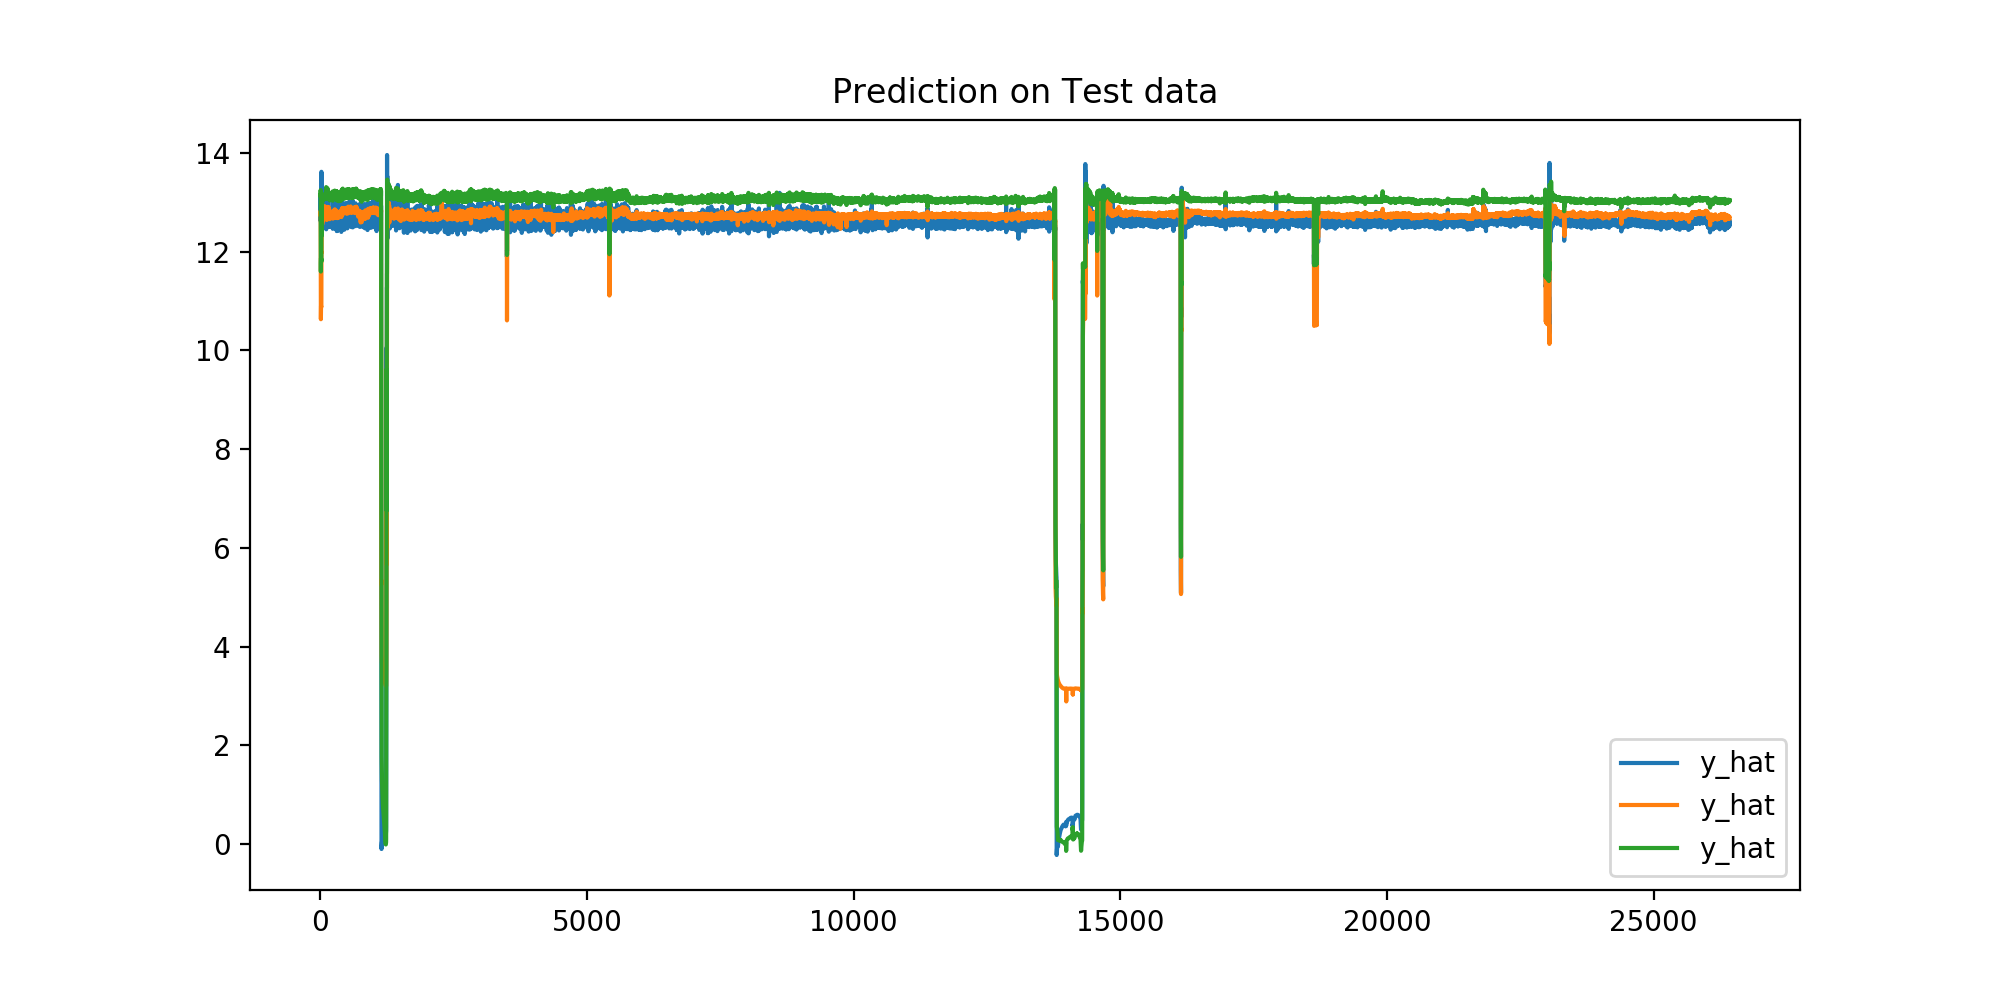

In [140]:
T = pd.to_datetime(data.timestamp, unit='ms')
plt.figure(figsize=(10, 5))
#plt.plot( y, label='y', color = 'red')
plt.title("Prediction on Test data")
plt.plot(model1.predict(X_test1), label='y_hat')
plt.plot(model2.predict(X_test2), label='y_hat')
plt.plot(model3.predict(X_test3), label='y_hat')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


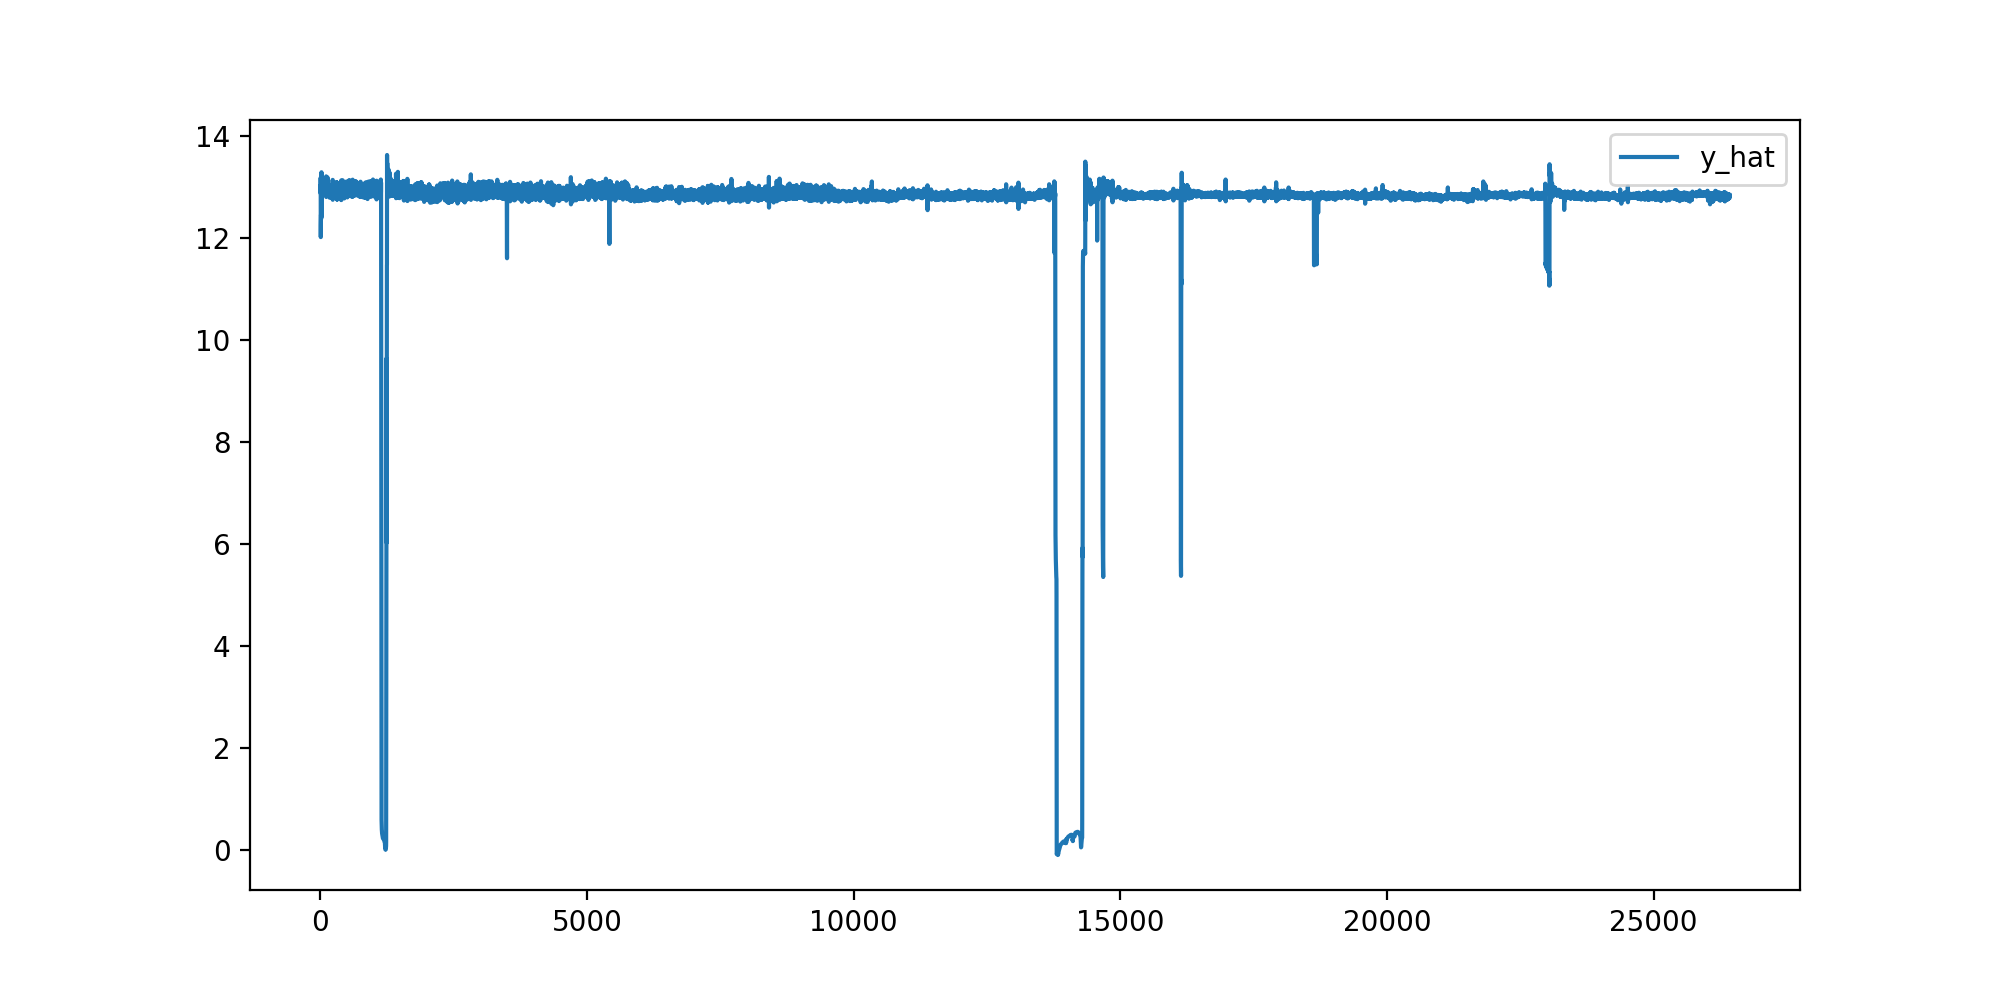

In [121]:
T = pd.to_datetime(data.timestamp, unit='ms')
plt.figure(figsize=(10, 5))
#plt.plot( y, label='y', color = 'red')
plt.plot((model1.predict(X_test1) + model3.predict(X_test3))/2 , label='y_hat')
plt.legend()
plt.show()

In [156]:
pred_df = data.loc[76423:,:]
pred_df['VAL_23-PT-92539:X.Value|average'] = (model1.predict(X_test1) + model3.predict(X_test3))/2
pred_df.to_csv('prediction_df.csv')

/Users/school/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


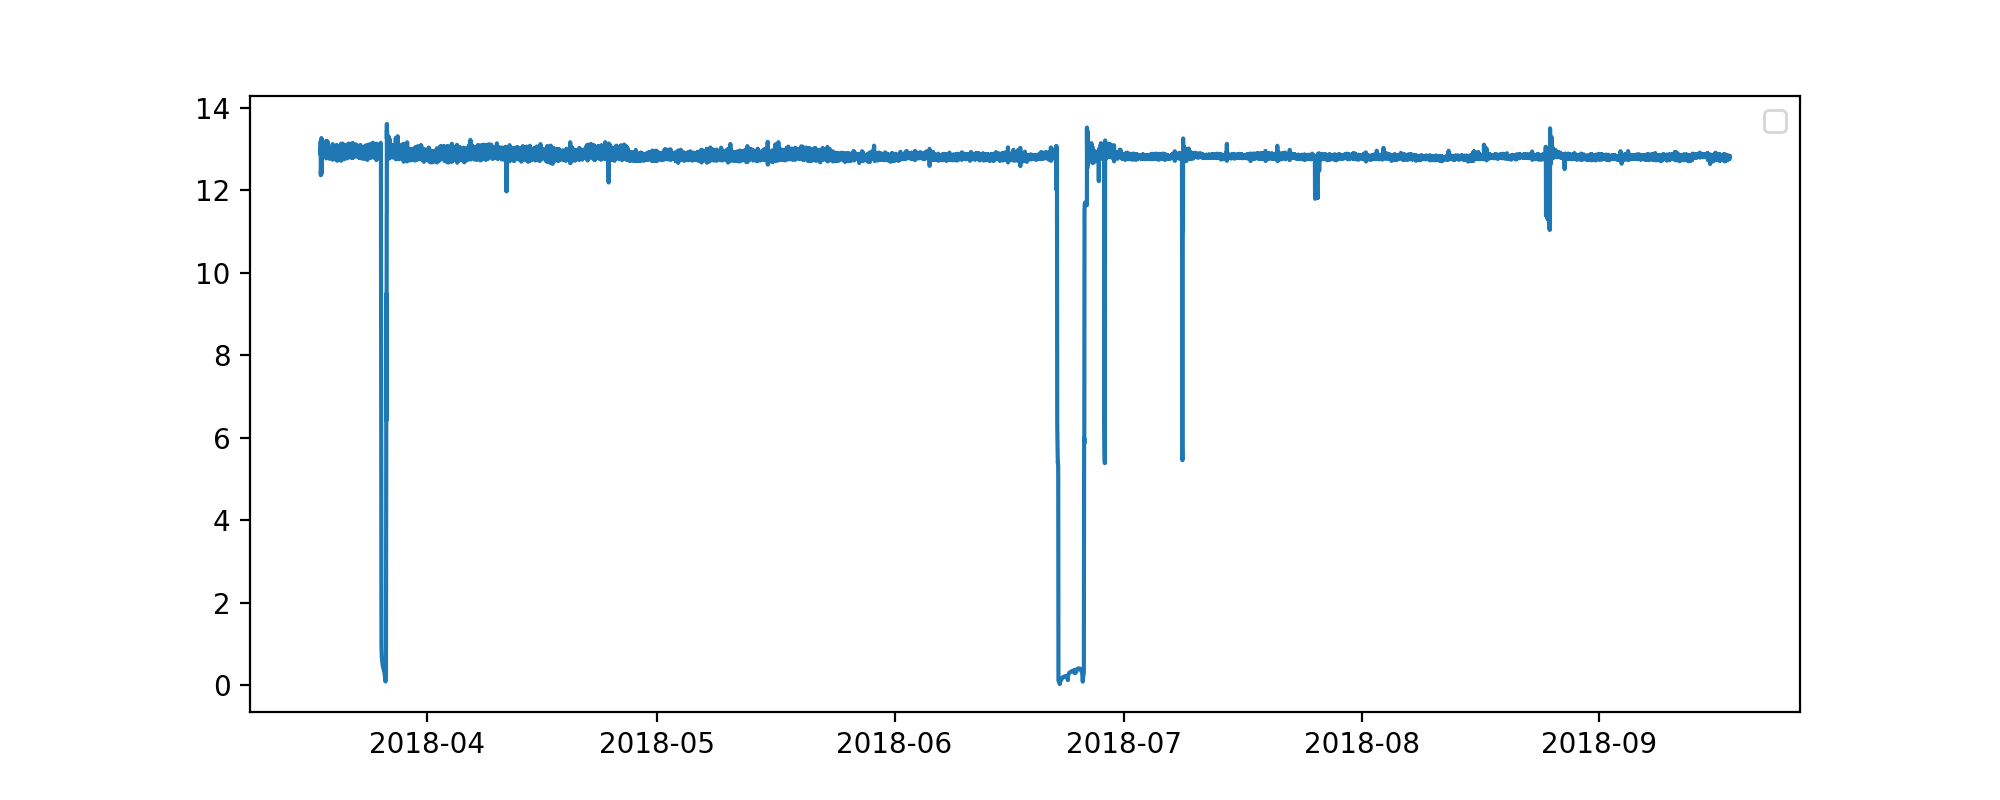

No handles with labels found to put in legend.


In [157]:
T = pd.to_datetime(pred_df.timestamp, unit='ms')
plt.figure(figsize=(10, 4))
plt.plot(T, pred_df['VAL_23-PT-92539:X.Value|average'].values)
plt.legend()
plt.show()